In this Jupyter Notebook, we are going to train a neural network using the `fashion_mnist` dataset. We use TensorFlow and Keras to build and train the model. After training, we'll evaluate the model, make some predictions, and then save the model for use in a web browser with TensorFlow.js.

## Dependencies

First, we'll install the necessary dependencies. TensorFlow.js is needed for exporting the model to use in a browser environment.

In [1]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

Next, we'll import the libraries we'll use in this notebook.



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam

## Loading the Dataset

We're using the `fashion_mnist` dataset, which contains 70,000 grayscale images in 10 categories. Each image shows individual articles of clothing at low resolution (28 by 28 pixels).

In [3]:
data, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVE3RHO/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVE3RHO/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpziwz56wttfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

The dataset is already split into a training set and a test set. We'll separate these into different variables.

In [5]:
train_data, test_data = data['train'], data['test']

The class names are not included with the dataset, so we'll save them into a list for later use.



In [6]:
class_names = metadata.features['label'].names

In [7]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Preprocessing the Data

The pixel values fall in the range of 0 to 255. We'll normalize these values to the range of 0 to 1.

In [8]:
#normalizing from  [0-255] to [0-1]
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

#normalize training and test data with normalization function
train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

#Add data to cache (speed by memory usage)
train_data = train_data.cache()
test_data = test_data.cache()

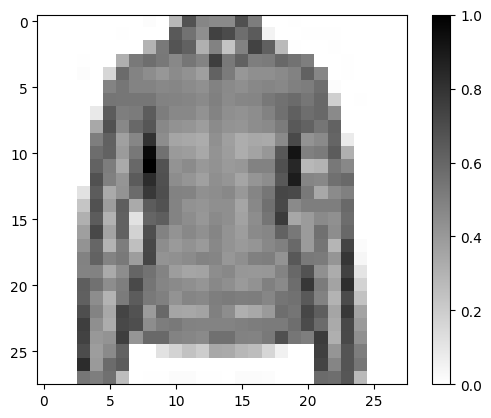

In [9]:
#Display an image of the test data, display first.

for image, label in test_data.take(1):
  break
image = image.numpy().reshape((28,28)) # Resize

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

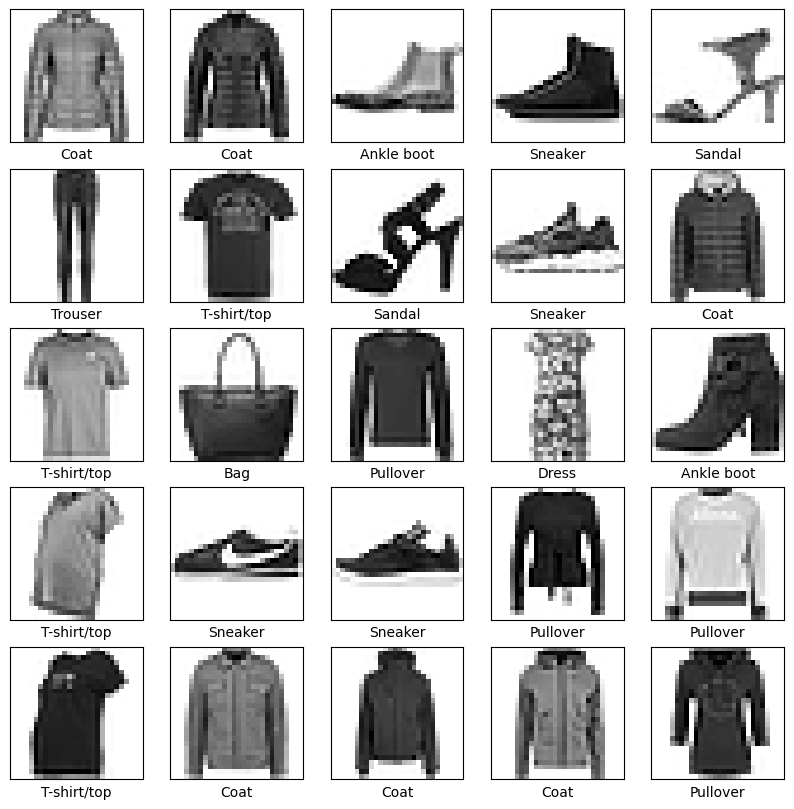

In [10]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_data.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show

## Building the Model

We'll use a simple feedforward neural network for this task.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.3),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.3),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

## Compiling the Model

We'll use the Adam optimizer, and the sparse categorical crossentropy loss function.

In [12]:
#Compile
model.compile(
    optimizer = Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [13]:
amount_train = metadata.splits["train"].num_examples
amount_test = metadata.splits["test"].num_examples
print(f"The number of examples for training is: {amount_train}")
print(f"The number of examples for test is: {amount_test}")

The number of examples for training is: 60000
The number of examples for test is: 10000


## Training the Model

The model will be trained for 10 epochs. Early stopping and model checkpoint callbacks are used.

In [14]:
batch_size = 32
train_data = train_data.repeat().shuffle(amount_train).batch(batch_size)
test_data = test_data.batch(batch_size)

In [15]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_data, epochs=10, steps_per_epoch=math.ceil(amount_test/batch_size), 
           validation_data=test_data, callbacks=[early_stop, checkpoint])

Epoch 1/10
313/313 [==============================] - 11s 10ms/step - loss: 1.0116 - accuracy: 0.6626 - val_loss: 0.6641 - val_accuracy: 0.7651
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 0.6753 - accuracy: 0.7648 - val_loss: 0.5300 - val_accuracy: 0.8100
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 0.5755 - accuracy: 0.7992 - val_loss: 0.5452 - val_accuracy: 0.8144
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 0.5696 - accuracy: 0.8014 - val_loss: 0.4957 - val_accuracy: 0.8220
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 0.5505 - accuracy: 0.8095 - val_loss: 0.4679 - val_accuracy: 0.8338
Epoch 6/10
313/313 [==============================] - 2s 7ms/step - loss: 0.5432 - accuracy: 0.8066 - val_loss: 0.5177 - val_accuracy: 0.8068
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 0.5255 - accuracy: 0.8133 - val_loss: 0.4903 - val_accuracy: 0.8218
Epoc

## Evaluating the Model

First, the loss value is plotted over time.

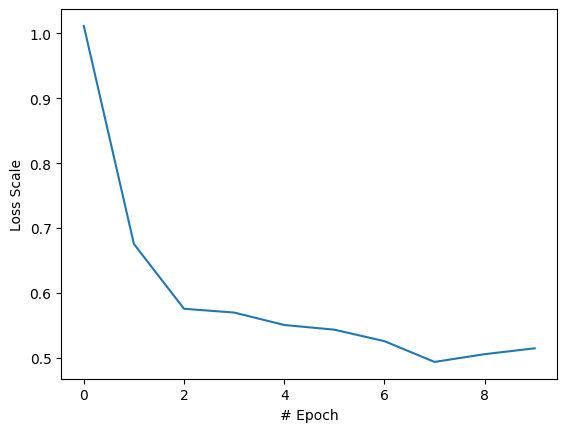

In [16]:
plt.xlabel("# Epoch")
plt.ylabel("Loss Scale")
plt.plot(history.history['loss'])

1/1 [==============================] - 0s 116ms/step


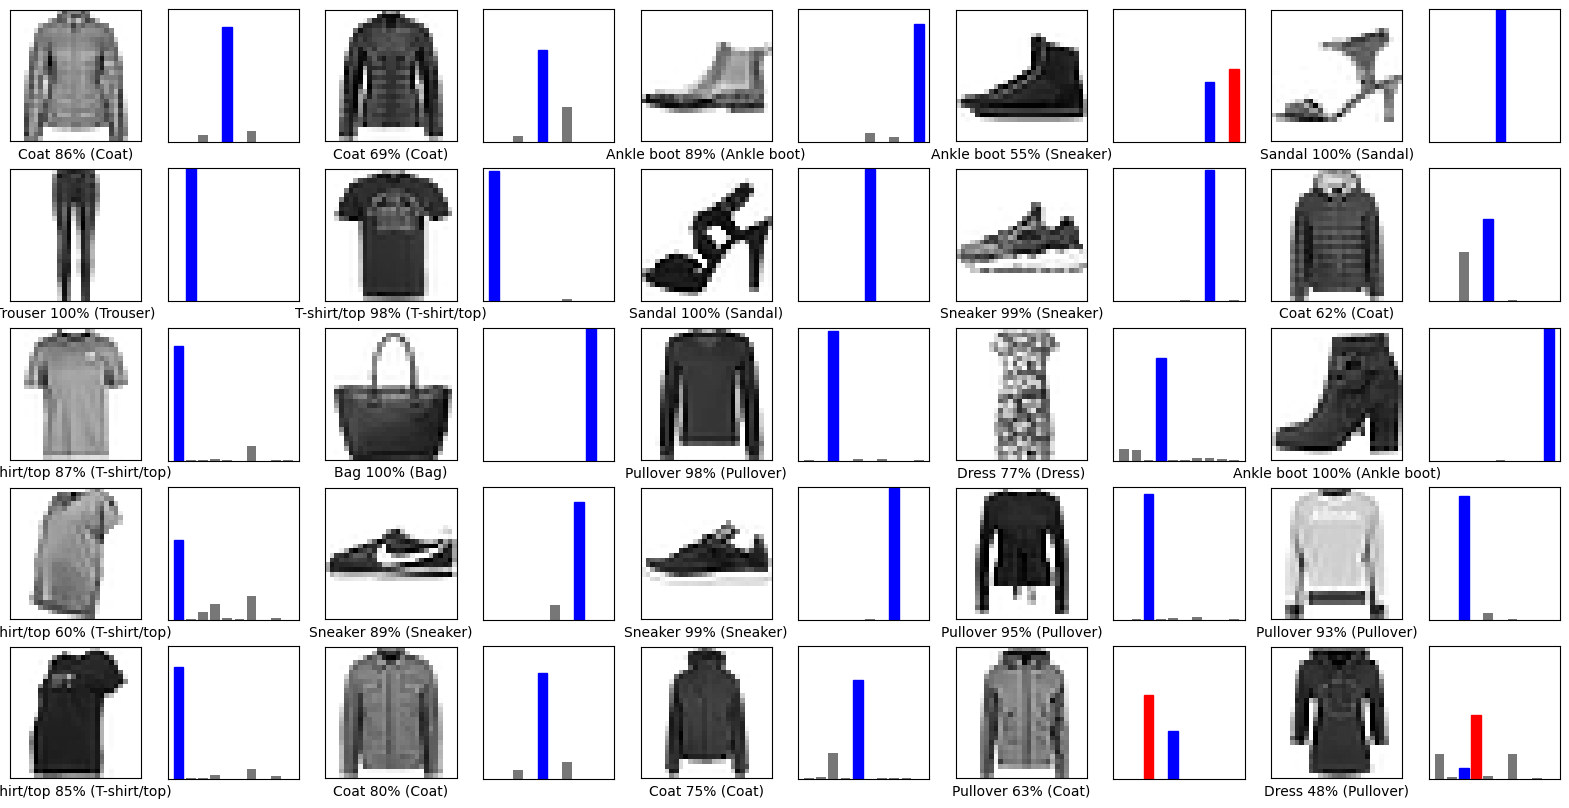

In [17]:
for img_test, label_test in test_data.take(1):
  predictions = model.predict(img_test)

def img_graphic(i, arr_predictions, real_label, image):
    arr_predictions, real_label, img = arr_predictions[i], real_label[i], image[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    label_prediction = tf.argmax(arr_predictions).numpy()
    if label_prediction == real_label:
        color = 'blue' #Prediccion correcta
    else:
        color = 'red' #Prediccion incorrecta

    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[label_prediction],
        100*tf.reduce_max(arr_predictions).numpy(),
        class_names[real_label],
        color=color
    ))

def value_array_image(i, arr_predictions, real_label):
    arr_predictions, real_label = arr_predictions[i], real_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    graphique = plt.bar(range(10), arr_predictions, color="#777777")
    plt.ylim([0,1])
    
    label_prediction = tf.argmax(arr_predictions).numpy()
    graphique[label_prediction].set_color('red')
    graphique[real_label].set_color('blue')

row = 5
columns = 5
num_image = row * columns
plt.figure(figsize=(2*2*columns, 2*row))
for i in range (num_image):
    plt.subplot(row, 2*columns, 2*i+1)
    img_graphic(i, predictions, label_test, img_test)
    plt.subplot(row, 2*columns, 2*i+2)
    value_array_image(i, predictions, label_test)

In [18]:
import numpy as np

#Acceder a culaquier indice del set de pruebas para ver su prediccion
image = img_test[5]
image = np.array([image])
prediccion = model.predict(image)

print("Prediccion: " + class_names[tf.argmax(prediccion[0]).numpy()])

1/1 [==============================] - 0s 129ms/step
Prediccion: Trouser


Next, the model is evaluated using the test dataset.



In [19]:
# we evaluate the model with the test data
evaluation = model.evaluate(test_data, verbose=2)
print(f'Test accuracy of the model: {evaluation[1]*100:.2f}%')

313/313 - 1s - loss: 0.4257 - accuracy: 0.8447 - 812ms/epoch - 3ms/step
Test accuracy of the model: 84.47%


## Saving the Model

Finally, we'll save the model in the h5 format and then convert it to the TensorFlow.js format.

In [20]:
#Export to Tensorflow.js
model.save('exported_model.h5')

!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras exported_model.h5 tfjs_target_dir

2023-06-09 02:09:52.692767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
